# 2. Use of openAlex data

OpenAlex returns the following publication metadata:

- Authors
- Author position
- Author PIDs
- Author affiliations and institutional PIDs
- Title
- Year
- Abstract
- Concepts and their relatedness to the paper under consideration
- is open access
- …

-> these data can answer some relevant questions:

Where do the authors work? The more recent the publication the more likely the affiliation on the publication is the current place of work. More up-to-date information could be found on their ORCID profile.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # version 3.5.2
import fiona
import geopandas as gpd
import pickle
from itertools import groupby

## Functions

In [44]:
def freq_country_codes(df):
    # get list of countries with authors
    countries = list(df["inst_country_code"])
    # remove None values + alphabetical
    countries = sorted([i for i in countries if i is not None])
    
    # count how many of each group (country)
    freqs = [len(list(group)) for key, group in groupby(countries)]
    
    # link counts to country codes
    freqs_dict = {}
    for i, country in enumerate(sorted(set(countries))):
        freqs_dict[country] = freqs[i]

    return freqs_dict

In [78]:
# get worldmap 
def plot_country_freqs(freqs, map_path, europe=False):
    worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

    # convert 3-letter codes to 2-letter codes used for frequencies
    country_codes = pd.read_csv("countries_codes_and_coordinates.csv")
    country_codes = country_codes.applymap(lambda x: x.replace(' "', ""))
    country_codes = country_codes.applymap(lambda x: x.replace('"', ""))
    
    worldmap = worldmap.rename(columns={"iso_a3":"Alpha-3 code"})
    worldmap = pd.merge(worldmap, country_codes[["Alpha-2 code", "Alpha-3 code"]], 
                        on="Alpha-3 code", how="left")
    # fix problem with France
    worldmap.at[43,"Alpha-2 code"] = "FR"

    # add frequencies to worldmap
    worldmap["freq"] = worldmap["Alpha-2 code"].map(freqs)
    worldmap["freq"].fillna(0, inplace=True)
            
    # plot frequencies
    if not europe:
        fig, ax = plt.subplots(1,1)
        worldmap.plot(column='freq', ax=ax, legend=True)
        plt.savefig(map_path+".png")
    
    if europe:
        fig, ax = plt.subplots(1, 1)
        minx, miny, maxx, maxy = [-25, 30, 45, 80]
        ax.set_xlim(minx, maxx)
        ax.set_ylim(miny, maxy)

        europemap = worldmap.loc[worldmap["continent"] == "Europe"]
        europemap.plot(column='freq', ax=ax, legend=True)
        plt.savefig(map_path+"_europe.png")

## Results

In [39]:
single_authors = pd.read_pickle("./data/single_authors.pkl")
single_authors

,article_id,author_position,author_id,author_display_name,orcid,raw_affiliation_string,inst_id,inst_display_name,ror,inst_country_code,...,host_display_name,publisher,host_type,host_url,is_host_oa,host_version,host_license,is_oa,oa_status,oa_url
0,https://openalex.org/W3171440873,first,https://openalex.org/A2302825528,Gianni Allegro,https://orcid.org/0000-0002-5079-6671,"Strada Patro 11, I-14036 Moncalvo (AT), Italy ...",None,"Strada Patro 11, I-14036 Moncalvo (AT), Italy ...",None,None,...,ZooKeys,Pensoft Publishers,journal,https://zookeys.pensoft.net/article/60072/down...,True,publishedVersion,cc-by,True,gold,https://zookeys.pensoft.net/article/60072/down...
1,https://openalex.org/W2970477522,middle,https://openalex.org/A2902336126,Andrew F. Magee,https://orcid.org/0000-0002-7403-5455,"Department of Biology, University of Washingto...",https://openalex.org/I201448701,University of Washington,https://ror.org/00cvxb145,US,...,Systematic Biology,Oxford University Press,journal,None,False,None,None,True,green,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...
2,https://openalex.org/W2970773727,middle,https://openalex.org/A2902336126,Andrew F. Magee,https://orcid.org/0000-0002-7403-5455,"Department of Biology, University of Washingto...",https://openalex.org/I201448701,University of Washington,https://ror.org/00cvxb145,US,...,Systematic Biology,Oxford University Press,journal,None,False,None,None,True,bronze,https://academic.oup.com/sysbio/article-pdf/69...
3,https://openalex.org/W2553678995,last,https://openalex.org/A2706737904,Mehmet Faruk Gürbüz,None,"Department of Biology, Faculty of Art and Scie...",https://openalex.org/I175124709,Süleyman Demirel University,https://ror.org/04fjtte88,TR,...,Zootaxa,Q15088586,journal,None,False,None,None,False,closed,None
4,https://openalex.org/W2294609271,middle,https://openalex.org/A2100425372,Frazer Sinclair,https://orcid.org/0000-0001-5017-3215,"Institute of Evolutionary Biology, University ...",https://openalex.org/I98677209,University of Edinburgh,https://ror.org/01nrxwf90,GB,...,Zootaxa,Q15088586,journal,None,False,None,None,False,closed,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75417,https://openalex.org/W3015845240,last,https://openalex.org/A235841599,María Ana Tovar-Hernández,https://orcid.org/0000-0002-5263-2830,"Universidad Autónoma de Nuevo León, Facultad d...",https://openalex.org/I169046204,Universidad Autónoma de Nuevo León,https://ror.org/01fh86n78,MX,...,Zootaxa,Q15088586,journal,None,False,None,None,False,closed,None
75418,https://openalex.org/W3173633418,middle,https://openalex.org/A1222944398,Fortunato Garza-Ocañas,https://orcid.org/0000-0003-3862-8875,"Universidad Autónoma de Nuevo León, Campus Lin...",https://openalex.org/I169046204,Universidad Autónoma de Nuevo León,https://ror.org/01fh86n78,MX,...,Phytotaxa,Q15088586,journal,None,False,None,None,False,closed,None
75419,https://openalex.org/W4308950459,middle,https://openalex.org/A4308950570,ZHEN WANG,https://orcid.org/0000-0002-2450-4508,,None,None,None,None,...,Phytotaxa,Q15088586,journal,None,False,None,None,False,closed,None
75420,https://openalex.org/W1919372707,last,https://openalex.org/A1851838551,Yair Ben-Dov,https://orcid.org/0000-0001-7685-6727,"Department of Entomology, Agricultural Researc...",https://openalex.org/I376102,Agricultural Research Organization,https://ror.org/05hbrxp80,IL,...,Zootaxa,Q15088586,journal,None,False,None,None,False,closed,None


In [57]:
countries_freq = freq_country_codes(single_authors)
countries_freq

{'AE': 10,
 'AF': 1,
 'AL': 14,
 'AM': 16,
 'AO': 5,
 'AR': 883,
 'AT': 334,
 'AU': 1449,
 'AZ': 7,
 'BA': 7,
 'BB': 2,
 'BD': 51,
 'BE': 488,
 'BF': 12,
 'BG': 90,
 'BI': 1,
 'BJ': 25,
 'BM': 1,
 'BN': 16,
 'BO': 33,
 'BR': 5074,
 'BS': 6,
 'BT': 4,
 'BW': 7,
 'BY': 16,
 'BZ': 5,
 'CA': 994,
 'CD': 21,
 'CG': 7,
 'CH': 335,
 'CI': 10,
 'CL': 298,
 'CM': 65,
 'CN': 8971,
 'CO': 705,
 'CR': 120,
 'CU': 51,
 'CV': 4,
 'CW': 1,
 'CY': 24,
 'CZ': 594,
 'DE': 1697,
 'DK': 198,
 'DO': 10,
 'DZ': 59,
 'EC': 159,
 'EE': 36,
 'EG': 88,
 'ER': 1,
 'ES': 1332,
 'ET': 24,
 'FI': 186,
 'FJ': 5,
 'FK': 2,
 'FM': 1,
 'FR': 1019,
 'GA': 9,
 'GB': 1513,
 'GE': 22,
 'GF': 7,
 'GH': 8,
 'GL': 2,
 'GN': 7,
 'GP': 6,
 'GQ': 1,
 'GR': 184,
 'GT': 29,
 'GY': 1,
 'HK': 7,
 'HN': 13,
 'HR': 101,
 'HU': 241,
 'ID': 206,
 'IE': 71,
 'IL': 119,
 'IN': 2193,
 'IQ': 22,
 'IR': 678,
 'IS': 24,
 'IT': 1001,
 'JE': 5,
 'JM': 4,
 'JO': 3,
 'JP': 1256,
 'KE': 73,
 'KG': 3,
 'KH': 15,
 'KP': 6,
 'KR': 581,
 'KW': 6,
 'KZ

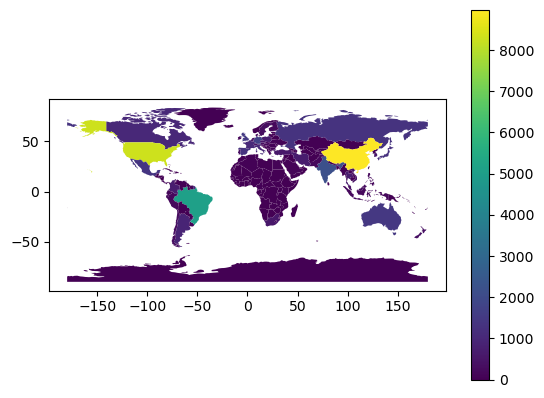

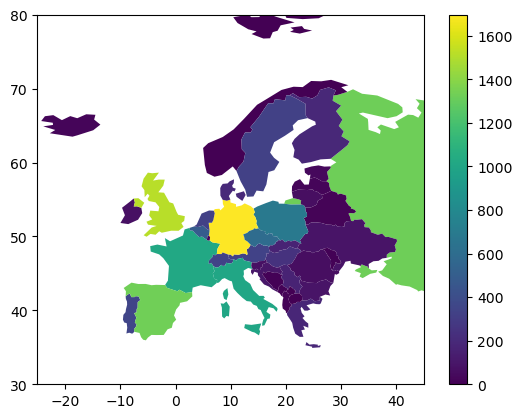

In [86]:
plot_country_freqs(countries_freq, "./figures/map_all_journals")
plot_country_freqs(countries_freq, "./figures/map_all_journals", europe=True)

In [85]:
eujot_freq = freq_country_codes(single_authors[single_authors["host_display_name"]=="European journal of taxonomy"])
eujot_freq

{'AR': 14,
 'AT': 7,
 'AU': 18,
 'BD': 2,
 'BE': 52,
 'BF': 1,
 'BG': 4,
 'BJ': 1,
 'BO': 1,
 'BR': 122,
 'BS': 1,
 'BW': 1,
 'CA': 10,
 'CD': 3,
 'CH': 6,
 'CL': 4,
 'CM': 3,
 'CN': 98,
 'CO': 9,
 'CR': 4,
 'CZ': 23,
 'DE': 63,
 'DK': 18,
 'DZ': 1,
 'EC': 3,
 'EG': 1,
 'ES': 44,
 'ET': 1,
 'FI': 9,
 'FR': 76,
 'GA': 1,
 'GB': 40,
 'GP': 2,
 'GR': 8,
 'GT': 1,
 'HN': 1,
 'HR': 5,
 'HU': 4,
 'ID': 6,
 'IL': 3,
 'IN': 47,
 'IR': 18,
 'IS': 1,
 'IT': 58,
 'JP': 13,
 'KE': 2,
 'KG': 1,
 'KH': 3,
 'KR': 2,
 'LA': 1,
 'LK': 4,
 'LT': 3,
 'LU': 2,
 'MG': 4,
 'MX': 34,
 'MY': 4,
 'NG': 1,
 'NL': 8,
 'NO': 6,
 'NZ': 10,
 'PE': 5,
 'PH': 2,
 'PK': 8,
 'PL': 17,
 'PT': 15,
 'RE': 5,
 'RO': 4,
 'RS': 20,
 'RU': 40,
 'RW': 2,
 'SA': 6,
 'SE': 15,
 'SG': 2,
 'SI': 8,
 'SK': 8,
 'SL': 1,
 'SN': 2,
 'TH': 16,
 'TN': 4,
 'TR': 8,
 'TW': 10,
 'TZ': 2,
 'UA': 1,
 'US': 77,
 'UY': 2,
 'VE': 1,
 'VN': 23,
 'ZA': 10}

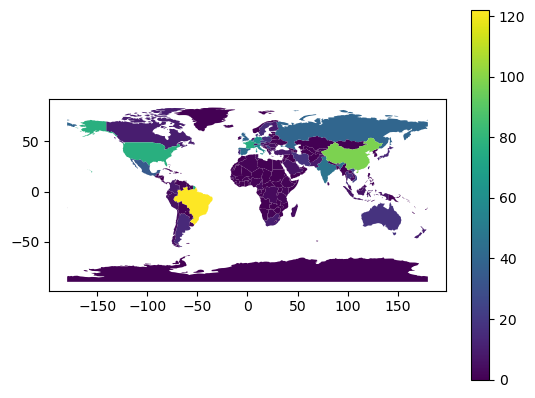

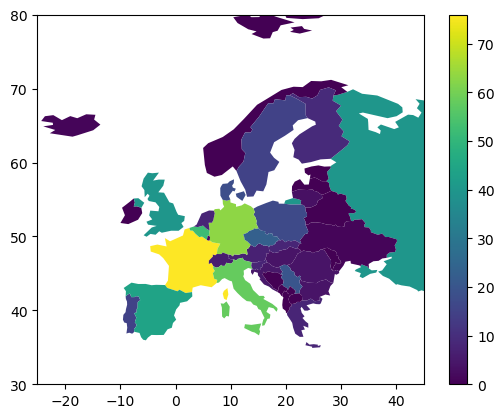

In [87]:
plot_country_freqs(eujot_freq, "./figures/map_eujot")
plot_country_freqs(eujot_freq, "./figures/map_eujot", europe=True)

In [84]:
set(single_authors["host_display_name"])

{'Animal Systematics, Evolution and Diversity',
 'Australian Systematic Botany',
 'Bionomina',
 'European journal of taxonomy',
 'Graellsia',
 'Insect systematics and diversity',
 'Journal of Systematics and Evolution',
 'Kew Bulletin',
 'Korean Journal of Plant Taxonomy',
 'Megataxa',
 'Molecular Phylogenetics and Evolution',
 'Native Plants Journal',
 'NeoBiota',
 'Nuytsia',
 'PhytoKeys',
 'Phytotaxa',
 'Russian entomological journal',
 'Singmulbullyuhakoeji',
 'Systematic Biology',
 'Systematic Entomology',
 'Taxon',
 'The Auk',
 'The Bulletin of zoological nomenclature',
 'Willdenowia',
 'ZooKeys',
 'Zoologica Scripta',
 'Zoosystematics and Evolution',
 'Zootaxa'}